In [1]:
import os

os.chdir("../")

['STIXSizeFourSym', 'DejaVu Sans Display', 'cmtt10', 'STIXNonUnicode', 'DejaVu Serif', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'STIXGeneral', 'STIXSizeFiveSym', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans Mono', 'STIXSizeTwoSym', 'cmmi10', 'DejaVu Serif Display', 'cmss10', 'DejaVu Sans', 'STIXSizeTwoSym', 'STIXNonUnicode', 'DejaVu Sans', 'STIXSizeFourSym', 'cmex10', 'cmsy10', 'DejaVu Sans Mono', 'STIXGeneral', 'STIXSizeThreeSym', 'DejaVu Serif', 'cmb10', 'STIXGeneral', 'STIXGeneral', 'STIXNonUnicode', 'DejaVu Serif', 'STIXNonUnicode', 'STIXSizeThreeSym', 'DejaVu Serif', 'cmr10', 'STIXSizeOneSym', 'STIXSizeOneSym', 'Century', 'Lucida Bright', 'Candara', 'Monospac821 BT', 'Swis721 BlkEx BT', 'Leelawadee', 'ISOCT3', 'Garamond', 'Bodoni MT', 'Elephant', 'Franklin Gothic Medium', 'Old English Text MT', 'Bodoni MT', 'Trebuchet MS', 'Verdana', 'Nirmala UI', 'Artifakt Element', 'Centaur', 'Dubai', 'Nirmala UI', 'BankGothic Lt BT', 'Bodoni MT', 'Swis721 BdOul BT', 'Arial Rounded MT Bold', 'Arial

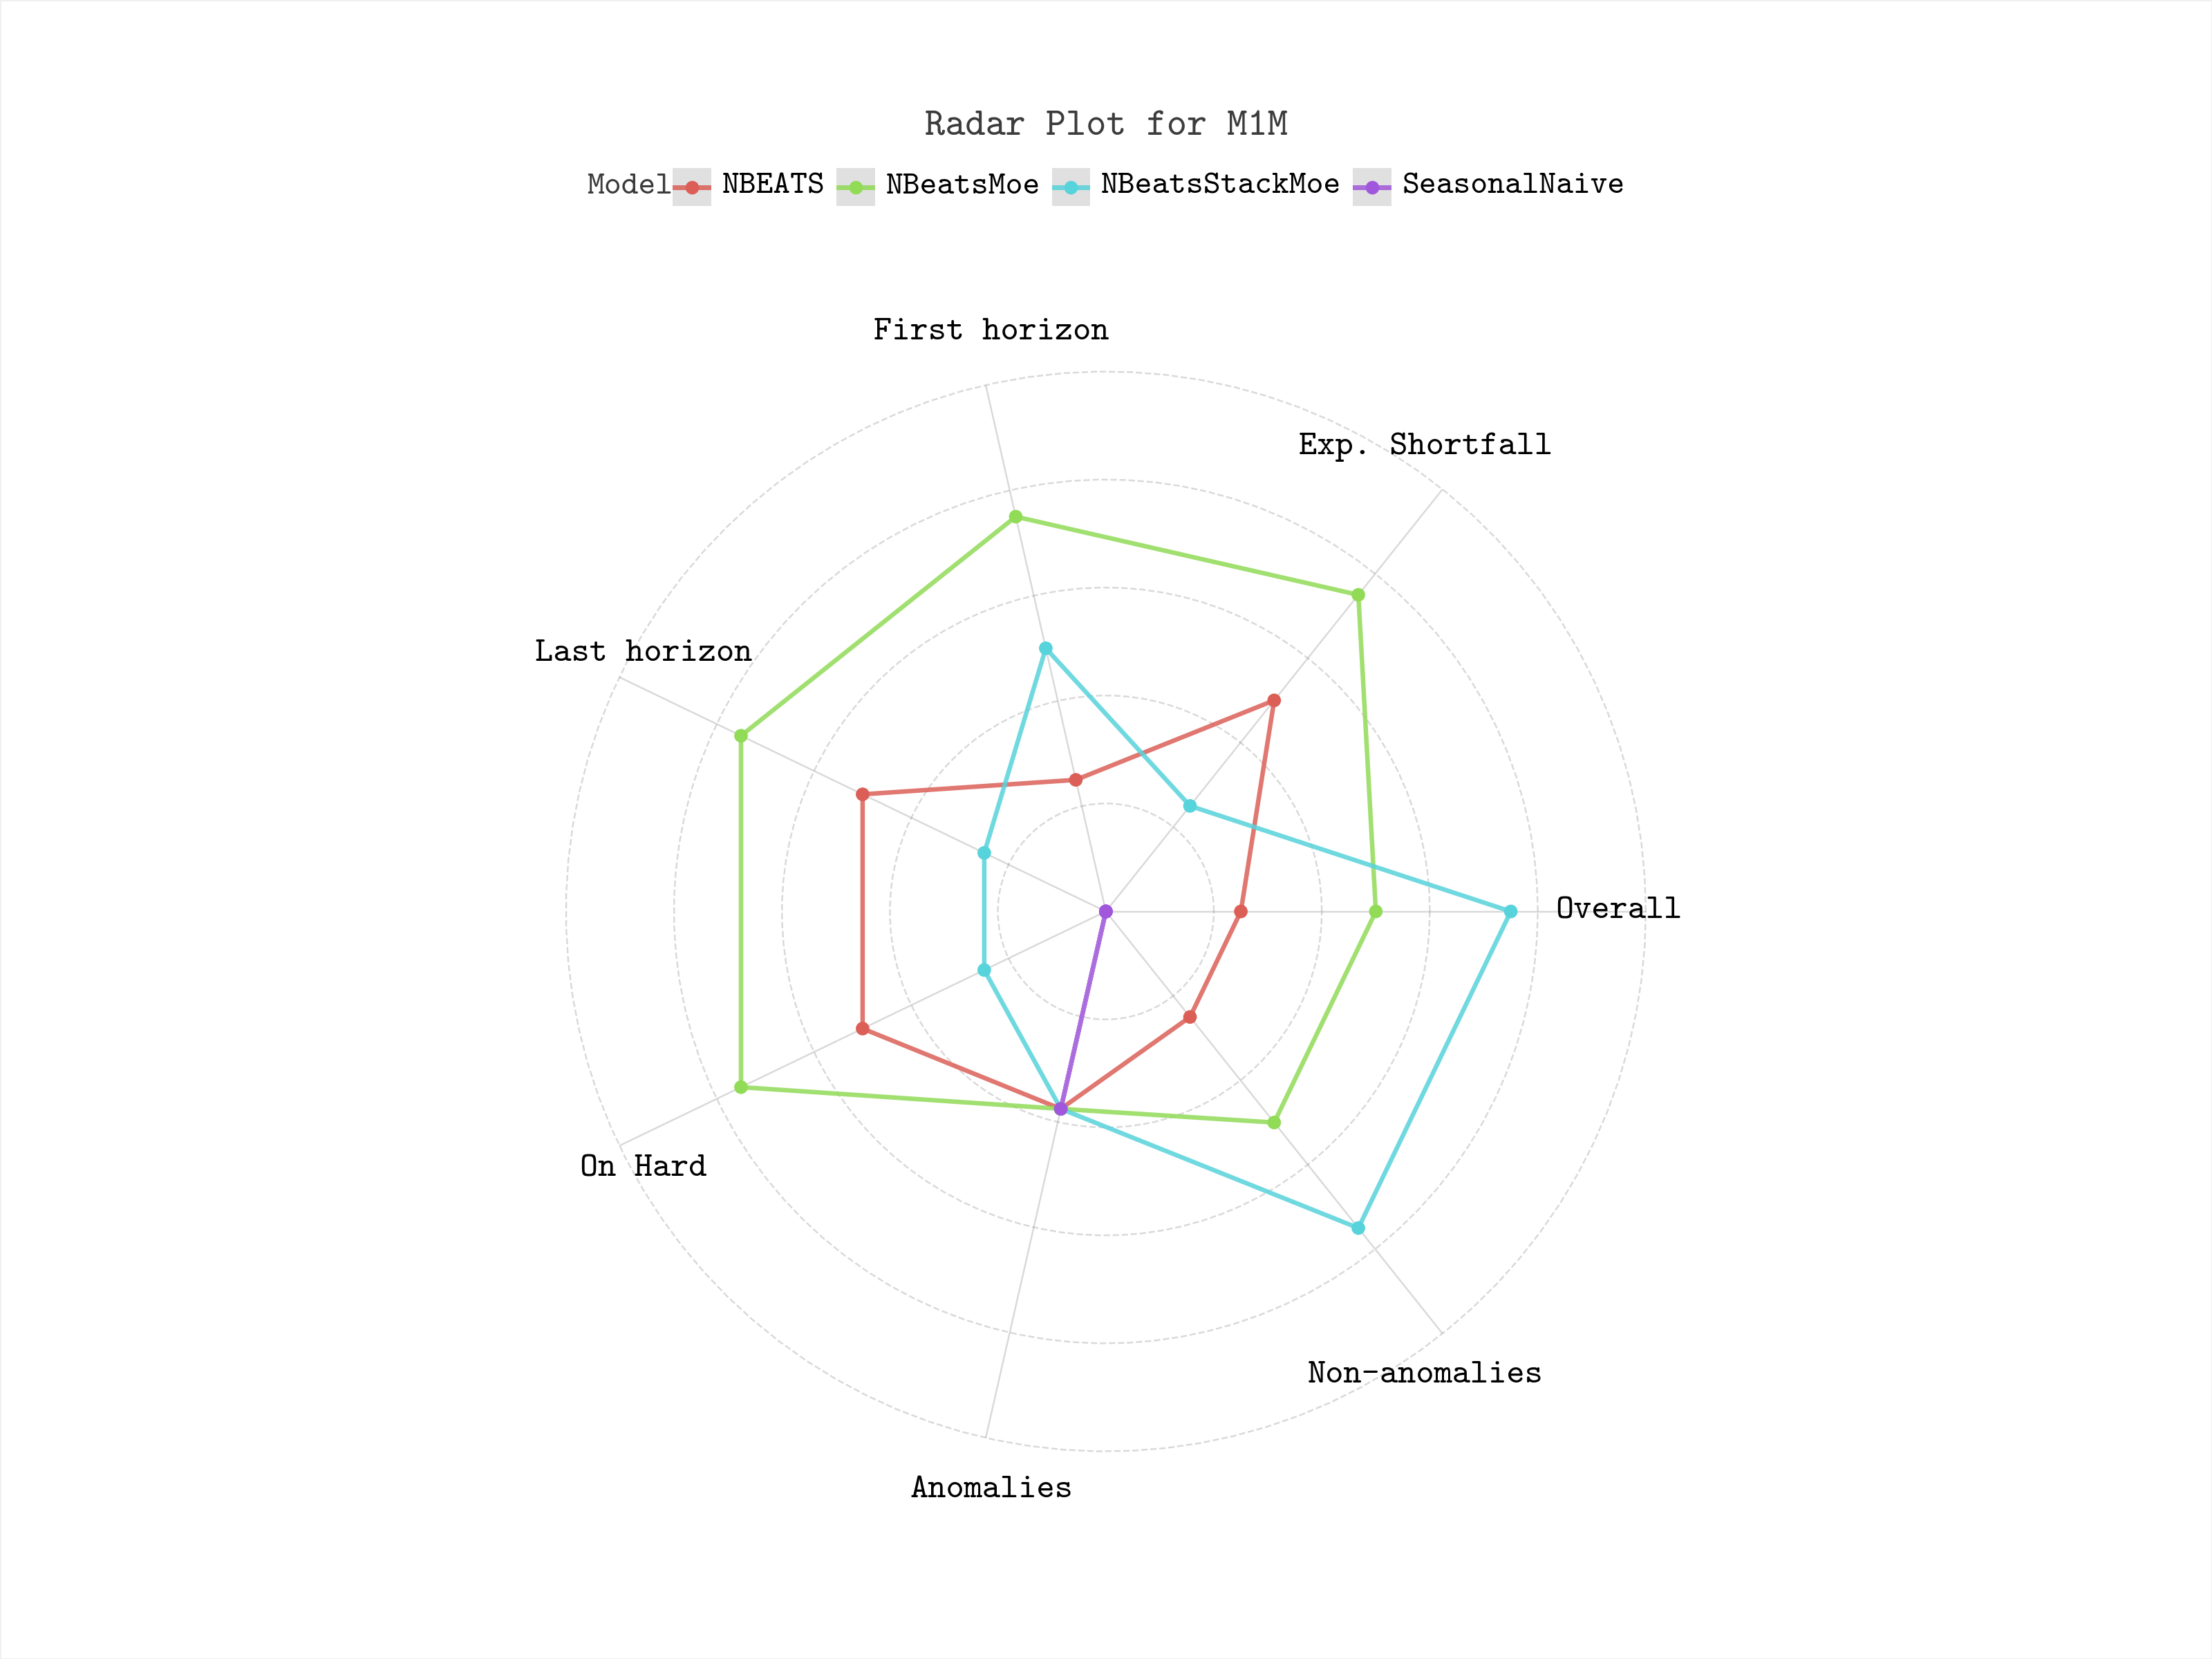

In [35]:
import re
import pandas as pd
from datasetsforecast.m4 import M4
from utilsforecast.losses import smape, mape, rmae, mae, mase, rmse, rmsse
from functools import partial

rmae_func = partial(rmae, baseline='SeasonalNaive')

# from utils import load_dataset, train_test_split
from modelradar.evaluate.radar import ModelRadar
from modelradar.visuals.plotter import ModelRadarPlotter, SpiderPlot
import plotnine as p9
import matplotlib.pyplot as plt


mase_func = partial(mase, seasonality=1)

dataset = 'm1m'
file_path = 'results,gluonts,m1_monthly.csv'

df = pd.read_csv(file_path)
train = pd.read_csv(re.sub('results','train', file_path))

radar = ModelRadar(cv_df=df,
                    # metrics=[smape],
                    # metrics=[rmae_func],
                    metrics=[mase_func],
                    model_names=['NBeatsMoe', 'NBEATS', 'NBeatsStackMoe', 'SeasonalNaive'],
                    hardness_reference='SeasonalNaive',
                    ratios_reference='NBEATS',
                    cvar_quantile=0.75,
                    hardness_quantile=0.75,
                    agg_func='median',
                    train_df=train,
                    rope=10)

err = radar.evaluate(keep_uids=True)
radar.uid_accuracy.get_hard_uids(err, return_df=False)
hard_uid_list = radar.uid_accuracy.hard_uid

err_hard = err.loc[hard_uid_list, :]
# err_anomalies = radar.evaluate_by_anomaly(anomaly_col='is_anomaly', mode='observations')

es_err = radar.uid_accuracy.expected_shortfall(err)
es_errh = radar.uid_accuracy.expected_shortfall(err_hard)
wdl = radar.rope.get_winning_ratios(err)


err_hard = radar.uid_accuracy.get_hard_uids(err)

df_plot = pd.concat([radar.evaluate(return_plot=False),
            radar.uid_accuracy.expected_shortfall(err),
            radar.evaluate_by_horizon_bounds(),
            radar.uid_accuracy.accuracy_on_hard(err),
            radar.evaluate_by_group(group_col='anomaly_status')
            #error_on_trend,
            #error_on_seas
                ], axis=1)

df_plot.head()

import matplotlib.font_manager
available_fonts = [f.name for f in matplotlib.font_manager.fontManager.ttflist]
print(available_fonts)

plot = SpiderPlot.create_plot(df=df_plot, values='rank', include_title=False)
plot + p9.ggtitle(f"Radar Plot for {dataset.upper()}")  +  p9.theme(
    plot_margin=0.05,
    figure_size=(16, 12),
    legend_position='top',
    strip_text=p9.element_text(size=17, family='cmtt10'),
    plot_title=p9.element_text(size=20, family='cmtt10'),
    panel_grid=p9.element_blank(),
    legend_text=p9.element_text(size=17, family='cmtt10'),
    legend_key_size=20,
    legend_key_width=20,
    text=p9.element_text(size=17, family='cmtt10'),

    # These lines remove x/y axis elements
    axis_title_x=p9.element_blank(),
    axis_title_y=p9.element_blank(),
    axis_text_x=p9.element_blank(),
    axis_text_y=p9.element_blank(),
    axis_ticks=p9.element_blank(),
    axis_line=p9.element_blank()
)
                


In [38]:
from PIL import Image
import os
import math

Image.MAX_IMAGE_PIXELS = None  # Disable safety limit

folder_path = "plots"
resize_factor = 0.5

image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
images = [
    Image.open(os.path.join(folder_path, f)).resize(
        (int(Image.open(os.path.join(folder_path, f)).width * resize_factor),
         int(Image.open(os.path.join(folder_path, f)).height * resize_factor))
    ) for f in sorted(image_files)
]

img_width, img_height = images[0].size
n_images = len(images)
grid_cols = math.ceil(math.sqrt(n_images))
grid_rows = math.ceil(n_images / grid_cols)

combined_image = Image.new('RGB', (img_width * grid_cols, img_height * grid_rows), color='white')

for idx, img in enumerate(images):
    x_offset = (idx % grid_cols) * img_width
    y_offset = (idx // grid_cols) * img_height
    combined_image.paste(img, (x_offset, y_offset))

combined_image.save("combined_image.png")
